<a href="https://colab.research.google.com/github/suhas-arun/NLP-CW/blob/main/augmented_nlp_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages


In [12]:
!pip install transformers
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.0 MB/s eta 0:00:00


In [26]:
import pandas as pd
from dont_patronize_me import DontPatronizeMe

import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import torch
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from tqdm import tqdm
import ipywidgets as widgets
from IPython.display import display

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


Helper functions to save and load pre-trained model

# Download dataset

In [14]:
dpm = DontPatronizeMe(".", ".")
dpm.load_task1()
dpm.train_task1_df

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
3,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
10464,10465,@@14297363,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0,1
10465,10466,@@70091353,vulnerable,ph,He added that the AFP will continue to bank on...,0,0
10466,10467,@@20282330,in-need,ng,""""""" She has one huge platform , and informatio...",1,3
10467,10468,@@16753236,hopeless,in,""""""" Anja Ringgren Loven I ca n't find a word t...",1,4


In [15]:
trids = pd.read_csv("train_semeval_parids-labels.csv")
teids = pd.read_csv("dev_semeval_parids-labels.csv")

trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)

### Build internal training and dev sets


In [16]:
def get_data_for_ids(ids, data):
    rows = []
    for _, row in ids.iterrows():
        par_id = row["par_id"]
        data_row = data[data["par_id"] == par_id]
        keyword = data_row["keyword"].values[0]
        country = data_row["country"].values[0]
        text = data_row["text"].values[0]
        label = data_row["label"].values[0]
        rows.append({
            "par_id": par_id,
            "keyword": keyword,
            "country": country,
            "text": text,
            "label": label,
        })
    return pd.DataFrame(rows)

In [17]:
train_data = get_data_for_ids(trids, dpm.train_task1_df)
train_data

,par_id,keyword,country,text,label
0,4341,poor-families,gb,"The scheme saw an estimated 150,000 children f...",1
1,4136,homeless,za,Durban 's homeless communities reconciliation ...,1
2,10352,poor-families,lk,The next immediate problem that cropped up was...,1
3,8279,vulnerable,nz,Far more important than the implications for t...,1
4,1164,poor-families,gh,To strengthen child-sensitive social protectio...,1
...,...,...,...,...,...
8370,8380,refugee,gb,Rescue teams search for survivors on the rubbl...,0
8371,8381,hopeless,ke,The launch of ' Happy Birthday ' took place la...,0
8372,8382,homeless,pk,"The unrest has left at least 20,000 people dea...",0
8373,8383,hopeless,pk,You have to see it from my perspective . I may...,0


In [10]:
dev_data = get_data_for_ids(teids, dpm.train_task1_df)
dev_data

,par_id,keyword,country,text,label
0,4046,hopeless,us,We also know that they can benefit by receivin...,1
1,1279,refugee,ng,Pope Francis washed and kissed the feet of Mus...,1
2,8330,refugee,ng,Many refugees do n't want to be resettled anyw...,1
3,4063,in-need,ie,"""Budding chefs , like """" Fred """" , """" Winston ...",1
4,4089,homeless,pk,"""In a 90-degree view of his constituency , one...",1
...,...,...,...,...,...
2089,10462,homeless,gh,"The sad spectacle , which occurred on Saturday...",0
2090,10463,refugee,pk,""""""" The Pakistani police came to our house and...",0
2091,10464,disabled,ie,"""When Marie O'Donoghue went looking for a spec...",0
2092,10465,women,lk,"""Sri Lankan norms and culture inhibit women fr...",0


# Data Analysis

### Label Distribution


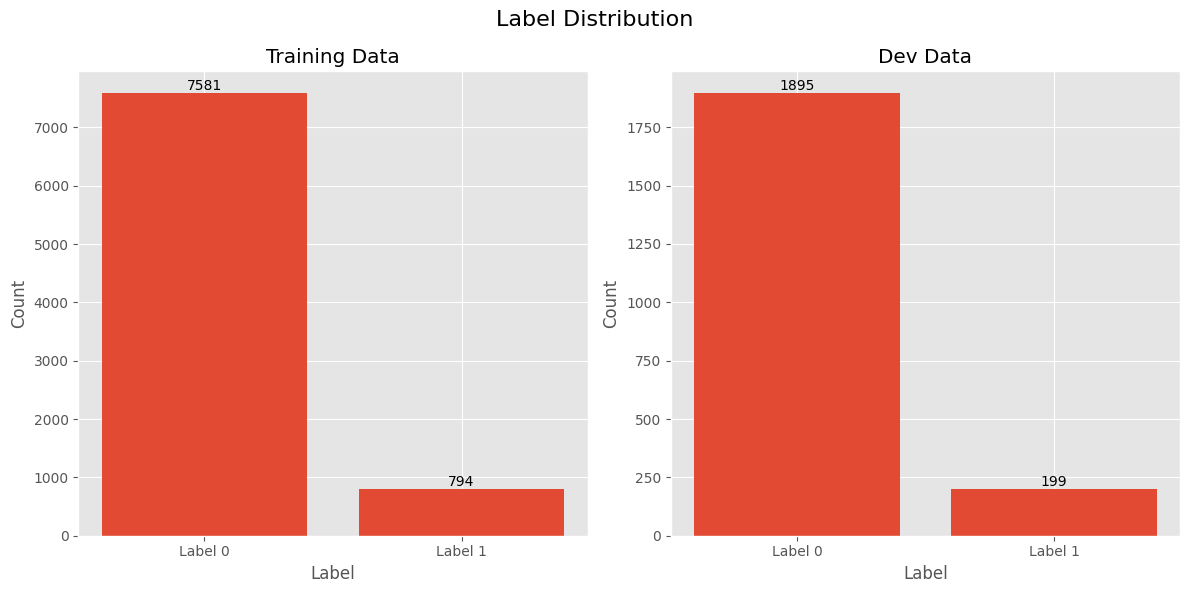

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')

# Train data plot
train_label_counts = train_data['label'].value_counts()
axes[0].bar(train_label_counts.index, train_label_counts.values)
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Label 0', 'Label 1'])
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_title("Training Data")

for i, count in enumerate(train_label_counts.values):
    axes[0].text(i, count + 0.1, str(count), ha='center', va='bottom')

# Dev data plot
dev_label_counts = dev_data['label'].value_counts()
axes[1].bar(dev_label_counts.index, dev_label_counts.values)
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Label 0', 'Label 1'])
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')
axes[1].set_title("Dev Data")

for i, count in enumerate(dev_label_counts.values):
    axes[1].text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.suptitle("Label Distribution", fontsize=16)
plt.tight_layout()
plt.show()

### Keyword Analysis


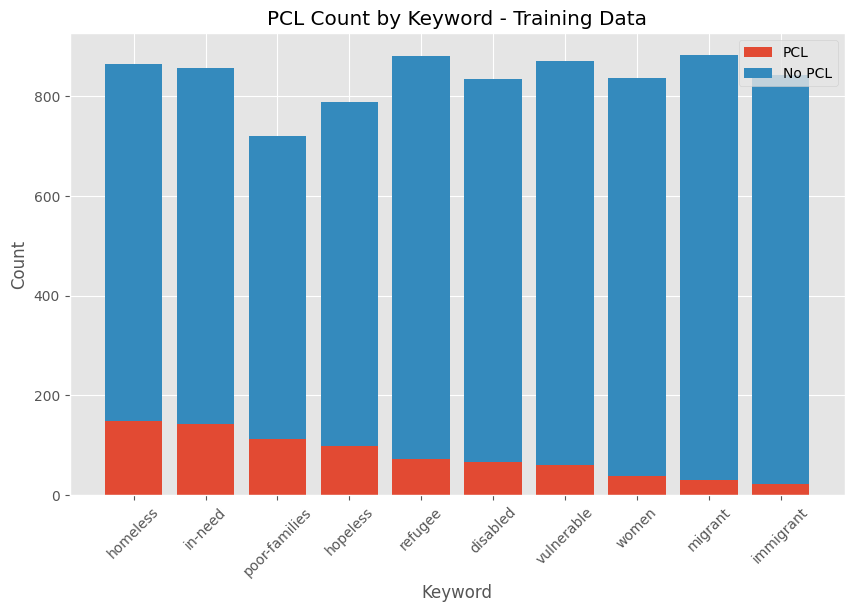

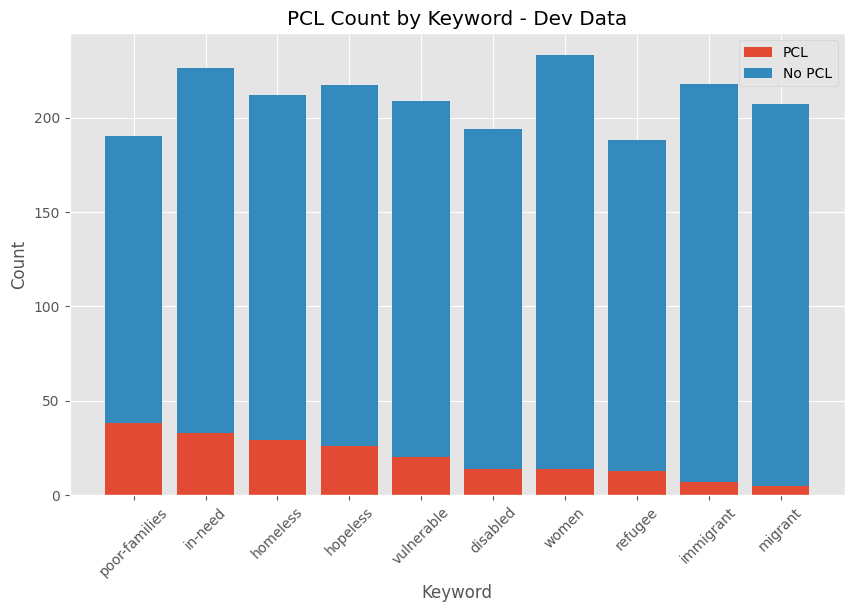

In [21]:
def plot_keyword_distribution(data, title):
    keyword_counts = data.groupby('keyword')['label'].value_counts().unstack().fillna(0)
    keyword_counts.columns = ['No PCL', 'PCL']
    keyword_counts = keyword_counts.reset_index()
    keyword_counts = keyword_counts.sort_values(by='PCL', ascending=False)
    # print(keyword_counts)

    keywords = keyword_counts["keyword"]

    plt.figure(figsize=(10, 6))
    plt.bar(keywords, keyword_counts['PCL'], label='PCL')
    plt.bar(keywords, keyword_counts['No PCL'], bottom=keyword_counts['PCL'], label='No PCL')

    plt.xticks(rotation=45)
    plt.xlabel('Keyword')
    plt.ylabel('Count')
    plt.title(title)
    plt.legend()
    plt.show()

plot_keyword_distribution(train_data, "PCL Count by Keyword - Training Data")
print()
plot_keyword_distribution(dev_data, "PCL Count by Keyword - Dev Data")

### Sequence Length Analysis


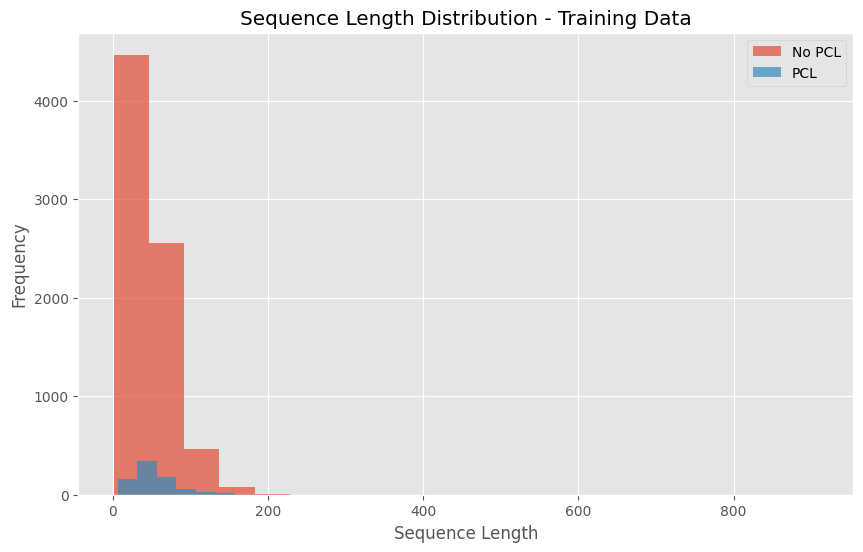

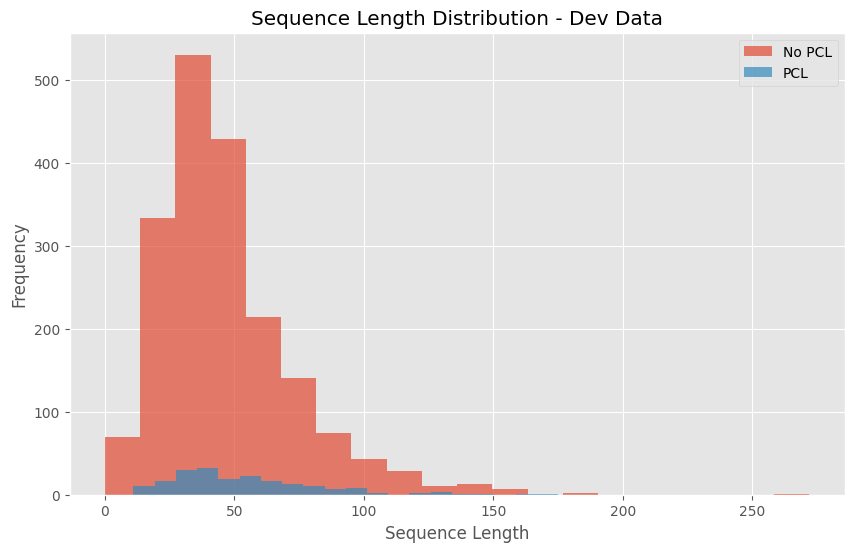

In [22]:
def plot_sequence_length_distribution(data, title):
    sequence_lengths = data['text'].apply(lambda x: len(x.split()))

    # Plot sequence lengths for labels "No PCL" and "PCL"
    plt.figure(figsize=(10, 6))

    pcl_lengths = sequence_lengths[data['label'] == 1]
    no_pcl_lengths = sequence_lengths[data['label'] == 0]

    plt.hist(no_pcl_lengths, bins=20, alpha=0.7, label='No PCL')
    plt.hist(pcl_lengths, bins=20, alpha=0.7, label='PCL')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()
    plt.show()


plot_sequence_length_distribution(train_data, "Sequence Length Distribution - Training Data")
print()
plot_sequence_length_distribution(dev_data, "Sequence Length Distribution - Dev Data")

# Data Preprocessing

In [23]:
# Preprocess text function

# Download nltk packages
nltk.download("stopwords")
nltk.download("punkt_tab")

def preprocess(text):
    text = str(text)
    # Lowercase
    text = text.lower()
    # Remove non-alphanumeric chars
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # Remove stopwords
    words = TextBlob(text).words
    filtered_words = [w for w in words if w.lower() not in stopwords.words("english")]
    text = " ".join(filtered_words)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [24]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.text = df["text"]
        self.labels = df["label"]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        encoding = self.tokenizer(
            self.text[index],
            padding="max_length",
            truncation=True,
            max_length=512,
        )
        item = {key: torch.tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[index])
        return item


In [25]:
train_data["text"] = (train_data["text"].apply(preprocess))
dev_data["text"] = (dev_data["text"].apply(preprocess))

# Data Augmentation

In [29]:
AUGMENTED_FILE_NAME = "augmented_data.csv"

### Synonym Replacement

In [48]:
import nlpaug.augmenter.word as naw

def replace_synonyms(df, target_label=1, model_name='distilroberta-base', augment_count=2):
    # Filter the dataframe for the target label
    target_df = df[df['label'] == target_label].copy()

    # Initialize the augmenter with the transformer model for contextual substitutions
    augmenter = naw.ContextualWordEmbsAug(model_path=model_name, action="substitute", device=device)

    # Iterate over target examples and generate augmented texts
    augmented_records = []
    for _, row in target_df.iterrows():
        try:
            aug_texts = augmenter.augment(row['text'], n=augment_count)
        except Exception:
            continue

        # Build new records for each augmented text
        for text in aug_texts:
            record = {
                'par_id': row['par_id'],
                'country': row['country'],
                'text': text,
                'label': target_label
            }
            augmented_records.append(record)

    # Create a DataFrame for the augmented examples and shuffle it
    augmented_df = pd.DataFrame(augmented_records).sample(frac=1, random_state=42).reset_index(drop=True)

    # Combine the original dataframe with the augmented dataframe
    combined_df = pd.concat([df, augmented_df], ignore_index=True)
    return combined_df

### Back Translation

In [50]:
from transformers import MarianMTModel, MarianTokenizer

def back_translate(train_df, lang_1 = 'en', lang_2 = 'fr', batch_size = 8):
    # Forward translation
    forward_translate_model_name = f"Helsinki-NLP/opus-mt-{lang_1}-{lang_2}"
    forward_translate_tokenizer = MarianTokenizer.from_pretrained(forward_translate_model_name)
    forward_translate_model = MarianMTModel.from_pretrained(forward_translate_model_name)
    forward_translate_model.to(device)

    # Backward translation
    backward_translate_model_name = f"Helsinki-NLP/opus-mt-{lang_2}-{lang_1}"
    backward_translate_tokenizer = MarianTokenizer.from_pretrained(backward_translate_model_name)
    backward_translate_model = MarianMTModel.from_pretrained(backward_translate_model_name)
    backward_translate_model.to(device)

    pos_examples = train_df[train_df['label'] == 1]
    texts = pos_examples['text'].tolist()

    augmented_pos_examples = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Forward pass
        forward_translated_inputs = forward_translate_tokenizer(
            batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512
        )
        forward_translated_inputs = {k: v.to(device) for k, v in forward_translated_inputs.items()}

        with torch.no_grad():
            forward_outputs = forward_translate_model.generate(**forward_translated_inputs)

        forward_translated_texts = [
            forward_translate_tokenizer.decode(output, skip_special_tokens=True)
            for output in forward_outputs
        ]

        # Backward pass
        backward_translated_inputs = backward_translate_tokenizer(
            forward_translated_texts, return_tensors="pt", truncation=True, padding=True, max_length=512
        )
        backward_translated_inputs = {k: v.to(device) for k, v in backward_translated_inputs.items()}

        with torch.no_grad():
            backward_outputs = backward_translate_model.generate(**backward_translated_inputs)

        backward_translated_texts = [
            backward_translate_tokenizer.decode(output, skip_special_tokens=True)
            for output in backward_outputs
        ]

        # Append augmented batch
        for j, backward_translated_text in enumerate(backward_translated_texts):
            row = pos_examples.iloc[i + j]
            augmented_pos_examples.append(
                (row['par_id'], row['keyword'], row['country'], backward_translated_text, 1)
            )

        print(f"Processed {i + batch_size}/{len(texts)} samples")

    augmented_pos_df = pd.DataFrame(
        augmented_pos_examples,
        columns=['par_id', 'keyword', 'country', 'text', 'label']
    )
    augmented_pos_df = augmented_pos_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return pd.concat([train_df, augmented_pos_df], ignore_index=True)

In [ ]:
def perform_augmentation(train_data):
    # Perform synonym replacement
    print("Performing synonym replacement...")
    augmented_train_data = replace_synonyms(train_data)

    # Perform back translation
    print("Performing back translation...")
    augmented_train_data = back_translate(augmented_train_data)

    # Save augmented data to file
    print("Saving augmented data to file...")
    augmented_train_data.to_csv(AUGMENTED_FILE_NAME, index=False)
    print(f"Augmentation complete. See {AUGMENTED_FILE_NAME}")

# DeBERTa Model


In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Helper Function to save a finetuned model
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print("Model saved successfully.")

# Helper Function to load a model

def load_deberta_model(path=None):
    deberta_model_name = "microsoft/deberta-v3-base"
    deberta_tokenizer = AutoTokenizer.from_pretrained(deberta_model_name)
    deberta_model = AutoModelForSequenceClassification.from_pretrained(deberta_model_name, num_labels=2)
    if path:
        # Load the trained weights
        deberta_model.load_state_dict(torch.load("deberta_finetuned.pth"))
    print("Model loaded successfully.")
    return deberta_model, deberta_tokenizer

In [ ]:
deberta_model, deberta_tokenizer = load_deberta_model()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
if os.path.exists(AUGMENTED_FILE_NAME):
    augmented_train_data = pd.read_csv(AUGMENTED_FILE_NAME)
    train_data = pd.concat([train_data, augmented_train_data], ignore_index=True)
    print("Augmented data loaded successfully.")
else:
    print("Using unaugmented data.")

deberta_train_dataset = CustomDataset(train_data, deberta_tokenizer)
deberta_dev_dataset = CustomDataset(dev_data, deberta_tokenizer)

In [ ]:
def train_model(model, train_loader, dev_loader, criterion, optimiser, num_epochs, model_path_to_save):
    train_losses = []
    train_f1_scores = []
    dev_losses = []
    dev_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []

        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False):
            optimiser.zero_grad()
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        train_f1 = f1_score(train_labels, train_preds)
        train_f1_scores.append(train_f1)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")

        model.eval()
        dev_loss = 0.0
        dev_preds = []
        dev_labels = []

        with torch.no_grad():
            for batch in tqdm(dev_loader, desc=f"Validating Epoch {epoch + 1}", leave=False):
                inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
                labels = batch['labels'].to(device)
                outputs = model(**inputs).logits
                loss = criterion(outputs, labels)
                dev_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                dev_preds.extend(preds.cpu().numpy())
                dev_labels.extend(labels.cpu().numpy())

        dev_loss /= len(dev_loader)
        dev_losses.append(dev_loss)

        dev_f1 = f1_score(dev_labels, dev_preds)
        dev_f1_scores.append(dev_f1)

        print(f"Epoch {epoch + 1}/{num_epochs}, Dev Loss: {dev_loss:.4f}, Dev F1: {dev_f1:.4f}")

    save_model(model, model_path_to_save)

    return train_losses, dev_losses, train_f1_scores, dev_f1_scores

In [ ]:
lr = 1e-5
num_epochs = 5
batch_size = 4

deberta_train_loader = DataLoader(deberta_train_dataset, batch_size, shuffle=True)
deberta_dev_loader = DataLoader(deberta_dev_dataset, batch_size)

deberta_model.to(device)
print("Num params:", sum(p.numel() for p in deberta_model.parameters()))

Num params: 184423682


In [ ]:
# Focal Loss implementation to use as criterion
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute log softmax for numerical stability
        logpt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(logpt)
        # Select the log probabilities corresponding to the target class
        logpt = logpt.gather(1, targets.unsqueeze(1))
        pt = pt.gather(1, targets.unsqueeze(1))
        # Compute the focal loss
        loss = -self.alpha * ((1 - pt) ** self.gamma) * logpt
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [ ]:
optimiser = torch.optim.Adam(deberta_model.parameters(), lr=lr)
criterion = FocalLoss()
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=1, gamma=0.9)

train_losses, dev_losses, train_f1_scores, dev_f1_scores = train_model(
    deberta_model,
    deberta_train_loader,
    deberta_dev_loader,
    criterion,
    optimiser,
    num_epochs,
    model_path_to_save="deberta_finetuned_augmented.pth"
)

# Baseline Models


## Skip-Gram

In [39]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.utils.class_weight import compute_class_weight


def document_vector(word2vec_model, doc_tokens, vector_size):
    """
    Create a document vector by averaging word vectors
    """
    # Filter out tokens not in the vocabulary
    doc_tokens = [token for token in doc_tokens if token in word2vec_model.wv.key_to_index]

    # Return zero vector if no tokens are in vocab
    if not doc_tokens:
        return np.zeros(vector_size)

    # Sum up all word vectors and divide by number of words
    return np.mean([word2vec_model.wv[token] for token in doc_tokens], axis=0)


def train_skipgram(train_data, dev_data, class_weight_dict, vector_size, window_size, min_count):
    print("Preprocessing data...")
    train_data['tokens'] = train_data['text'].apply(preprocess).apply(word_tokenize)
    dev_data['tokens'] = dev_data['text'].apply(preprocess).apply(word_tokenize)
    print("Preprocessing complete.")

    # Additional context from keywords and country
    train_data['full_tokens'] = train_data.apply(
        lambda row: [row['country']] + row['tokens'], axis=1
    )

    dev_data['full_tokens'] = dev_data.apply(
        lambda row: [row['country']] + row['tokens'], axis=1
    )

    word2vec_model = Word2Vec(
        sentences=train_data['full_tokens'].tolist(),
        vector_size=vector_size,
        window=window_size,
        min_count=min_count,
        sg=1, # Skip-gram model (sg=1)
        workers=4,
        epochs=20
    )

    train_vectors = np.array([
        document_vector(word2vec_model, tokens, vector_size)
        for tokens in train_data['full_tokens']
    ])

    test_vectors = np.array([
        document_vector(word2vec_model, tokens, vector_size)
        for tokens in dev_data['full_tokens']
    ])

    # Train classifier
    print("Training classifier...")
    classifier = LogisticRegression(random_state=42, max_iter=1000,class_weight=class_weight_dict)
    classifier.fit(train_vectors, train_data['label'])

    # Make predictions
    print("Making predictions...")
    train_predictions = classifier.predict(train_vectors)
    test_predictions = classifier.predict(test_vectors)

    # Evaluate model
    print("\nModel Evaluation:")
    print(f"Training Accuracy: {accuracy_score(train_data['label'], train_predictions):.4f}")
    print(f"Testing Accuracy: {accuracy_score(dev_data['label'], test_predictions):.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(dev_data['label'], test_predictions))
    print(f"F1 Score (Positive Class): {f1_score(dev_data['label'], test_predictions):.4f}")

In [41]:
def compute_class_weights(train_data):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_data['label']),
        y=train_data['label']
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    return class_weight_dict

In [42]:
skip_gram_data = train_data.copy()
class_weight_dict = compute_class_weights(skip_gram_data)

train_skipgram(skip_gram_data, dev_data, class_weight_dict, vector_size=100, window_size=10, min_count=1)

Preprocessing data...
Preprocessing complete.
Training classifier...
Making predictions...

Model Evaluation:
Training Accuracy: 0.7451
Testing Accuracy: 0.7493

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1895
           1       0.23      0.71      0.35       199

    accuracy                           0.75      2094
   macro avg       0.60      0.73      0.60      2094
weighted avg       0.89      0.75      0.80      2094

F1 Score (Positive Class): 0.3511


## Bag of Words (BoW)


In [44]:
from sklearn.feature_extraction.text import CountVectorizer

def train_BOW_model(train_data, dev_data, class_weight_dict):
    vectorizer = CountVectorizer(lowercase=True, stop_words='english')

    # Fit the vectorizer on the training set text
    X_train = vectorizer.fit_transform(train_data['text'])
    y_train = train_data["label"]

    # Transform the development/test set using the same vectorizer.
    X_test = vectorizer.transform(dev_data["text"])
    y_test = dev_data["label"]

    classifier = LogisticRegression(random_state=42, max_iter=1000, class_weight=class_weight_dict)
    classifier.fit(X_train, y_train)

    # Make predictions
    print("Making predictions...")
    train_predictions = classifier.predict(X_train)
    test_predictions = classifier.predict(X_test)

    # Evaluate model
    print("\nModel Evaluation:")
    print(f"Training Accuracy: {accuracy_score(train_data['label'], train_predictions):.4f}")
    print(f"Testing Accuracy: {accuracy_score(dev_data['label'], test_predictions):.4f}")
    print("\nClassification Report (Test Set):")
    print(classification_report(dev_data['label'], test_predictions))
    print(f"F1 Score (Positive Class): {f1_score(dev_data['label'], test_predictions):.4f}")

In [46]:
bow_data = train_data.copy()
class_weight_dict = compute_class_weights(bow_data)

train_BOW_model(bow_data, dev_data, class_weight_dict)

Making predictions...

Model Evaluation:
Training Accuracy: 0.9943
Testing Accuracy: 0.8615

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      1895
           1       0.30      0.35      0.32       199

    accuracy                           0.86      2094
   macro avg       0.62      0.63      0.62      2094
weighted avg       0.87      0.86      0.87      2094

F1 Score (Positive Class): 0.3224
